In [1]:
import nltk
import json
import string
import numpy as np
import pandas as pd
from nltk import pos_tag
import matplotlib.pyplot as plt
from gensim.models import Phrases
from nltk.corpus import stopwords
import src.nlp_helper as nlp_helper
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/douglasbouchet/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/douglasbouchet/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 1. CMU Dataset

## 1.1 Exploration

### 1.1.1 Timeline bias

We want to explore a movies dataset that includes movies in different streaming services.
First, we explore the CMU Dataset and if we find it interesting we'll just have
to add new columns representing the presence or not of each movie in each streaming service.

In [2]:
# load the CMU movies dataset
df = pd.read_csv('data/CMU/movie.metadata.tsv.gz',
                 sep='\t', header=None, compression='gzip')

df.columns = [
    'wikipedia_id',
    'freebase_id',
    'movie_name',
    'release_date',
    'boxoffice_revenue',
    'runtime',
    'languages',
    'countries',
    'genres'
]
df.release_date = pd.to_datetime(df.release_date, errors='coerce')
df.release_date.describe(datetime_is_numeric=True)

count                            74838
mean     1977-10-12 11:46:07.610037696
min                1888-01-01 00:00:00
25%                1956-01-01 00:00:00
50%                1985-05-18 12:00:00
75%                2004-01-01 00:00:00
max                2016-06-08 00:00:00
Name: release_date, dtype: object

In [3]:
df.release_date = pd.to_datetime(df.release_date, errors='coerce')
df.release_date.describe(datetime_is_numeric=True)

count                            74838
mean     1977-10-12 11:46:07.610037696
min                1888-01-01 00:00:00
25%                1956-01-01 00:00:00
50%                1985-05-18 12:00:00
75%                2004-01-01 00:00:00
max                2016-06-08 00:00:00
Name: release_date, dtype: object

<AxesSubplot: title={'center': 'CMU number of movies per year'}, ylabel='Frequency'>

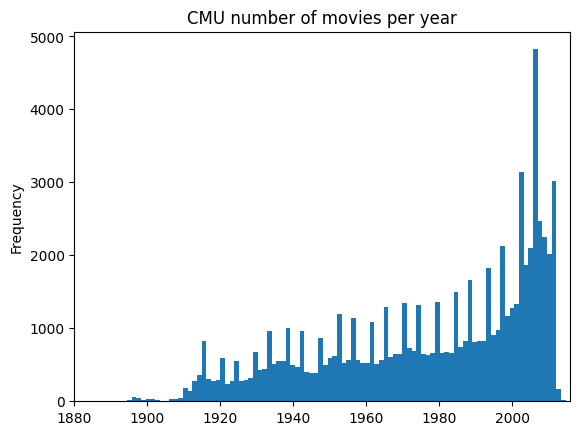

In [4]:
df.release_date.apply(lambda x: x.year).plot(kind='hist', bins=100, xlim=(
    1880, 2016), title='CMU number of movies per year')

### Interpretation
Looking at the statistics and the plot
of the release dates of the CMU dataset,
we can see that it mostly contains
old movies, only 1/4 of the movies have been released
after 2004, thus most movies are old,
this means that if we use this dataset to study
which streaming service is best our
dataset will have a bias towards older movies.
(As we will confirm in the next section)

### 1.1.2 Language bias

<AxesSubplot: xlabel='languages'>

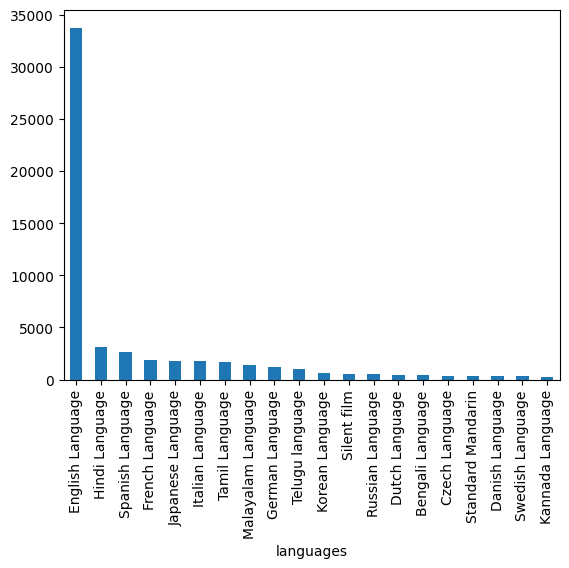

In [5]:
df.languages = df.languages.apply(json.loads)
df.languages = df.languages.apply(lambda x: tuple(list(x.values())))
# filter movies with more than one language
df = df[df.languages.apply(lambda x: len(x) == 1)]
df.languages = df.languages.apply(lambda x: x[0])
# plot number of movies in each language
df.languages.groupby(df.languages).count().sort_values(
    ascending=False).head(20).plot(kind='bar')

In [6]:
# number of english movies
df[df.languages == 'English Language'].shape[0]

33748

In [7]:
# number of non english movies
df[df.languages != 'English Language'].shape[0]

24320

### Interpretation
The dataset contains about 50% english movies amd 50% movies in a different language than english,
looking at movies that only have one spoken language in them. This shows a bias towards english movies

## 1.2 CMU Dataset suitability with our project

On the CMU website we see that the movies have been collected from the November 4,
2012 dump of Freebase. if we get data from google trends (see below),
we can see that the streaming services industry started booming after most of the movies
in the CMU dataset have been released.

![images/streaming.png](images/streaming.png)

![images/netflix.png](images/netflix.png)

![images/originals.png](images/originals.png)

We beleive that streaming services have generally more recent movies than old ones. To verify this we
will construct our own dataset using the imdb dataset and the moviedb api. This hypothesis will be proved
later (see next section)

# 2. Our newly constructed datasets

### 2.1 IMDb dataset exploration

let's explore this dataset and only keep information that is relevant to our project

In [8]:
df_movies = pd.read_csv('data/IMDb/title.basics.tsv.gz',
                        sep='\t', compression='gzip')
df_movies.head()

/var/folders/2v/f5sm00lj343gkrnlrbwvbls00000gn/T/ipykernel_83464/476350960.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_movies = pd.read_csv('data/IMDb/title.basics.tsv.gz',


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [9]:
# Only keep movies (no TV shows, no shorts, etc.)
df_movies = df_movies[df_movies.titleType == 'movie']
nb_movies = len(df_movies)
print(nb_movies)

627045


In [10]:
# Only keep movies with a known startYear
nb_with_no_rdate = len(df_movies[df_movies['startYear'] == '\\N'])
print(nb_with_no_rdate)

84637


In [11]:
# percentage of movies with no release date
nb_with_no_rdate / nb_movies * 100

13.497755344512754

<AxesSubplot: title={'center': 'IMDb number of movies per year'}, ylabel='Frequency'>

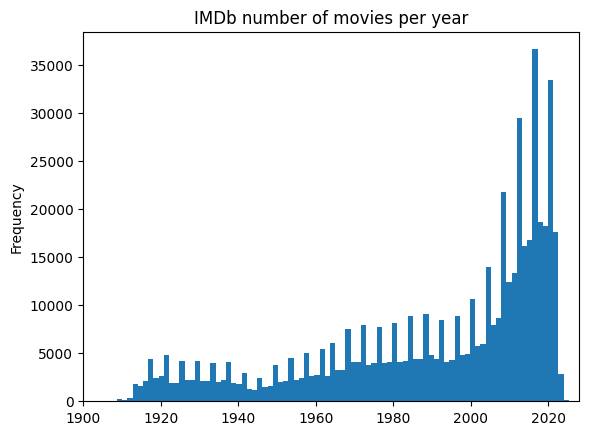

In [12]:
# plot the number of movies per year in a histogram
df_movies['startYear'] = pd.to_numeric(df_movies['startYear'], errors='coerce')
df_movies['startYear'].plot(kind='hist', bins=100,  xlim=(
    1900, 2028), title='IMDb number of movies per year')

In [13]:
df_movies['startYear'].describe()

count    542408.000000
mean       1990.724217
std          30.177087
min        1894.000000
25%        1972.000000
50%        2003.000000
75%        2015.000000
max        2028.000000
Name: startYear, dtype: float64

### Interpretation
The median is at the year 2003 (1985 for the CMU dataset). Our new dataset has more recent movies,
this is not the final dataset we will use, we will use the moviedb api
to get information on the availability of movies on streaming services.

## 2.2  The scraped data from the [moviedb API](https://developers.themoviedb.org/3)

### 2.2.1 Exploration

Given the imdb_id we scrape the overview, providers, bugdet, revenue, production
company, production country provided by the moviedb api. We will then only keep
relevant information for our project

In [14]:
df_new = pd.read_csv('data/moviedb_data.tsv.gz', sep='\t', compression='gzip')
df_new.head(5)

,imdb_id,overview,providers,budget,revenue,production_companies,production_countries
0,tt0000009,The adventures of a female reporter in the 1890s.,{},0,0,['Alexander Black Photoplays'],['US']
1,tt0000574,Just as Galeen and Wegener's Der Golem (1915) ...,{},0,0,"['Johnson and Gibson', 'J. & N. Tait']",['AU']
2,tt0000591,The first feature-length motion picture produc...,{},0,0,['Pathé Frères'],['FR']
3,tt0000615,Australian bushranger movie. The first filmed...,{},0,0,"[""MacMahon's Exquisite Pictures""]",[]
4,tt0000679,L. Frank Baum would appear in a white suit and...,{},0,0,['The Radio Play Company of America'],['US']


In [15]:
len(df_new)

289093

In [16]:
# Remove movies that dont have providers
df_new = df_new[df_new['providers'] != '{}']
# Parse the movies into python dicts
df_new['providers'] = df_new['providers'].apply(lambda x: json.dumps(x))
# Remove movies that dont have US streaming providers
df_new = df_new[df_new['providers'].apply(
    lambda prov_dict: ('US' in prov_dict))]
# Parses the providers into dicts


def get_json(row):
    return json.loads(row['providers'].replace("'", '"')[1:-1])


df_new['providers'] = df_new.apply(get_json, axis=1)
# Get the US providers list
df_new['providers'] = df_new['providers'].apply(lambda x: x['US'])
# Keep only movies that have a non empty list of providers
df_new = df_new[df_new['providers'].apply(lambda x: len(x) > 0)]
len(df_new)

38249

We have a list of about 40 000 movies to use for our analysis,
if we replace the "US" country code with "CH" we only get about
20 000 movies.

In [17]:
df_new['providers'] = df_new['providers'].apply(lambda x: tuple(x))
providers_list = list(set(df_new['providers']))
# flatten the list of tuples
providers_list = set([item for sublist in providers_list for item in sublist])
print(f'Number of different providers: {list(providers_list)}')
len(providers_list)

Number of different providers: ['Curiosity Stream', 'Fandor Amazon Channel', 'Discovery Plus', 'AMC+ Amazon Channel', 'HiDive', 'Sundance Now', 'HBO Max', 'DocAlliance Films', 'Amazon Prime Video', 'Lifetime Movie Club', 'Hulu', 'Starz Roku Premium Channel', 'KoreaOnDemand', 'Showtime Amazon Channel', 'Criterion Channel', 'ShortsTV Amazon Channel', 'Noggin Amazon Channel', 'Kocowa', 'Lifetime', 'Argo', 'Shudder', 'Apple TV Plus', 'Kanopy', 'Pantaya Amazon Channel', 'Hoopla', 'Discovery+ Amazon Channel', 'YouTube Free', 'Shudder Amazon Channel', 'Magnolia Selects', 'Epix Roku Premium Channel', 'Syfy', 'Paramount+ Amazon Channel', 'Showtime Roku Premium Channel', 'Disney Plus', 'Netflix Kids', 'True Story', 'AMC+', 'ARROW', 'PBS Masterpiece Amazon Channel', 'Pantaya', 'Bet+ Amazon Channel', 'BBC America', 'AsianCrush', 'Spectrum On Demand', 'Starz Amazon Channel', 'Paramount+ Roku Premium Channel', 'Peacock Premium', 'BroadwayHD', 'Showtime', 'Fandor', 'EPIX Amazon Channel', 'Starz', 'WO

134

We have a list of 134 providers, we will keep all of them for now
and see if we will reduce the number of providers later on.


In [18]:
df_joined = df_movies.merge(
    left_on='tconst', right_on='imdb_id', right=df_new, how='inner')
df_joined.isAdult = pd.to_numeric(df_joined.isAdult)
# remove column from dataframe
df_joined = df_joined.drop(['endYear', 'tconst', 'titleType'], axis=1)
df_joined = df_joined.drop('originalTitle', axis=1)
df_crew = pd.read_csv('data/IMDb/title.crew.tsv.gz',
                      sep='\t', compression='gzip')
df_names = pd.read_csv('data/IMDb/name.basics.tsv.gz',
                       sep='\t', compression='gzip')
df_joined = df_crew.merge(
    left_on='tconst', right_on='imdb_id', right=df_joined, how='inner')
df_joined = df_joined.drop('tconst', axis=1)

In [19]:
df_names

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0050419,tt0072308,tt0053137,tt0031983"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0117057,tt0037382,tt0038355,tt0071877"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department","tt0049189,tt0056404,tt0057345,tt0054452"
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0072562,tt0080455,tt0078723,tt0077975"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0083922,tt0060827,tt0050986,tt0050976"
...,...,...,...,...,...,...
12076733,nm9993714,Romeo del Rosario,\N,\N,"animation_department,art_department","tt14069590,tt2455546,tt11657662"
12076734,nm9993716,Essias Loberg,\N,\N,NaN,\N
12076735,nm9993717,Harikrishnan Rajan,\N,\N,cinematographer,tt8736744
12076736,nm9993718,Aayush Nair,\N,\N,cinematographer,\N


We now have the director and writers for each movie in our dataset,
they are identified by their imdb_id, we can lookup
the information about them in the df_names dataframe

In [20]:
df_joined

,directors,writers,primaryTitle,isAdult,startYear,runtimeMinutes,genres,imdb_id,overview,providers,budget,revenue,production_companies,production_countries
0,nm0646058,nm0310155,From the Manger to the Cross,0,1912.0,60,"Biography,Drama",tt0002199,The life of Jesus is played out in tableaux sh...,"(Amazon Prime Video, Paramount Plus, Paramount...",0,0,['Kalem Company'],['US']
1,nm0237713,"nm0078442,nm0348348,nm0612348,nm0715097",A Florida Enchantment,0,1914.0,63,Comedy,tt0003973,A young woman discovers a seed that can make w...,"(Amazon Prime Video, Paramount Plus, Epix Roku...",0,0,['Vitagraph Company of America'],['US']
2,nm0601190,"nm0509478,nm0518840",Joseph in the Land of Egypt,0,1914.0,52,Drama,tt0004179,Film realization of the Biblical story of Jose...,"(Fandor Amazon Channel,)",0,0,['Thanhouser Company'],['US']
3,nm0531759,nm0000875,The Patchwork Girl of Oz,0,1914.0,81,"Adventure,Comedy,Family",tt0004457,"Ojo and Unc Nunkie are out of food, so they de...","(Amazon Prime Video, Paramount Plus, Paramount...",0,0,['The Oz Film Manufacturing Company'],['US']
4,nm0950148,"nm0140902,nm0950148",Alice in Wonderland,0,1915.0,52,"Adventure,Family,Fantasy",tt0004873,Alice goes with her sister to a picnic and the...,"(Amazon Prime Video, EPIX Amazon Channel)",0,0,['Nonpareil Feature Film Corp.'],['US']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38244,nm1717924,nm9946633,The Hater,0,2020.0,135,"Drama,Thriller",tt9506474,A duplicitous young man finds success in the d...,"(Netflix, Netflix basic with Ads)",0,0,"['Canal+ Polska', 'TVN', 'K2studio', 'Naima Fi...",['PL']
38245,nm0902823,"nm0902823,nm4235496,nm10359068",Darkroom,0,2019.0,89,"Crime,Drama",tt9514116,"Lars, a male nurse from Saarbrücken, moves to ...","(Dekkoo,)",0,0,['Rosa von Praunheim Filmproduktion'],['DE']
38246,nm5443520,"nm1698564,nm0365057",Pershing's Paths of Glory,0,2018.0,46,Documentary,tt9516322,"In that spirit, Pershing's Paths of Glory pres...","(Hoopla,)",550000,0,['Pacific Film Foundation'],['US']
38247,nm1738082,"nm5160999,nm3374735,nm1807891,nm3372724,nm0443...",The Wedding Unplanner,0,2020.0,110,"Comedy,Romance",tt9519642,Marina is a woman in her thirties who works or...,"(HBO Max, DIRECTV)",0,3069303,"['Bazelevs Production', 'Itala Film', 'Lemon F...",['ES']


We will now add columns that correspond to ratings in our dataframe

In [21]:
df_ratings = pd.read_csv('data/IMDb/title.ratings.tsv.gz',
                         sep='\t', compression='gzip')
df_joined = df_ratings.merge(
    left_on='tconst', right_on='imdb_id', right=df_joined, how='inner')
df_joined = df_joined.drop('tconst', axis=1)
print('Columns of the joined dataframe:')
print(df_joined.columns)
df_joined.set_index('imdb_id', inplace=True)

Columns of the joined dataframe:
Index(['averageRating', 'numVotes', 'directors', 'writers', 'primaryTitle',
       'isAdult', 'startYear', 'runtimeMinutes', 'genres', 'imdb_id',
       'overview', 'providers', 'budget', 'revenue', 'production_companies',
       'production_countries'],
      dtype='object')


In [22]:
df_joined.head(5)

,averageRating,numVotes,directors,writers,primaryTitle,isAdult,startYear,runtimeMinutes,genres,overview,providers,budget,revenue,production_companies,production_countries
imdb_id,,,,,,,,,,,,,,,
tt0002199,5.8,596,nm0646058,nm0310155,From the Manger to the Cross,0,1912.0,60,"Biography,Drama",The life of Jesus is played out in tableaux sh...,"(Amazon Prime Video, Paramount Plus, Paramount...",0,0,['Kalem Company'],['US']
tt0003973,5.8,265,nm0237713,"nm0078442,nm0348348,nm0612348,nm0715097",A Florida Enchantment,0,1914.0,63,Comedy,A young woman discovers a seed that can make w...,"(Amazon Prime Video, Paramount Plus, Epix Roku...",0,0,['Vitagraph Company of America'],['US']
tt0004179,5.2,46,nm0601190,"nm0509478,nm0518840",Joseph in the Land of Egypt,0,1914.0,52,Drama,Film realization of the Biblical story of Jose...,"(Fandor Amazon Channel,)",0,0,['Thanhouser Company'],['US']
tt0004457,5.5,499,nm0531759,nm0000875,The Patchwork Girl of Oz,0,1914.0,81,"Adventure,Comedy,Family","Ojo and Unc Nunkie are out of food, so they de...","(Amazon Prime Video, Paramount Plus, Paramount...",0,0,['The Oz Film Manufacturing Company'],['US']
tt0004873,6.1,529,nm0950148,"nm0140902,nm0950148",Alice in Wonderland,0,1915.0,52,"Adventure,Family,Fantasy",Alice goes with her sister to a picnic and the...,"(Amazon Prime Video, EPIX Amazon Channel)",0,0,['Nonpareil Feature Film Corp.'],['US']


Lets explore what we have in the newly constructed dataframe,
 and check if it is suitable for our problem

<AxesSubplot: title={'center': 'Number of movies per release year'}, ylabel='Frequency'>

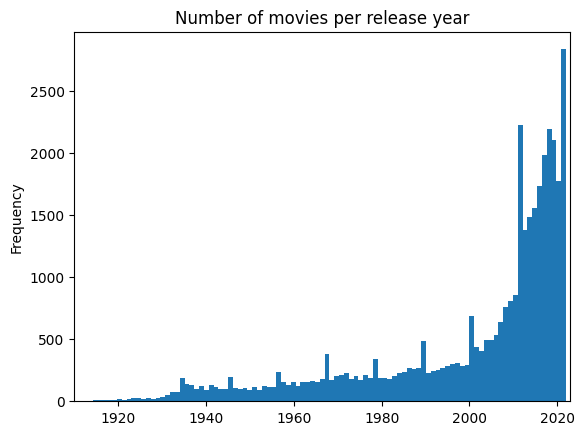

In [23]:
df_joined = df_joined.rename(columns={'startYear': 'release_year'})
# plot the release year of the movies
df_joined['release_year'].plot(kind='hist', bins=100, xlim=(
    1910, 2023), title='Number of movies per release year')

In [24]:
df_joined['release_year'].describe()

count    37273.000000
mean      2000.436965
std         23.617399
min       1912.000000
25%       1990.000000
50%       2011.000000
75%       2017.000000
max       2022.000000
Name: release_year, dtype: float64

We can now confirm our hypothesis from above that most movies on streaming sevices are recent movies,
50% of movies have been released after 2011, if we had used the CMU dataset we would have missed a
 lot of movies that are available on streaming services. Thus making our study limited to older movies.

### Cleaning and exploring the newly created dataset

In [25]:
# check for null values in columns
for col in df_joined.columns.to_list():
    print(col, df_joined[col].isnull().sum())

averageRating 0
numVotes 0
directors 0
writers 0
primaryTitle 0
isAdult 0
release_year 5
runtimeMinutes 0
genres 0
overview 384
providers 0
budget 0
revenue 0
production_companies 0
production_countries 0


In [26]:
# filter the 5 movies that have no release year
df_joined[df_joined['release_year'].isnull()]

,averageRating,numVotes,directors,writers,primaryTitle,isAdult,release_year,runtimeMinutes,genres,overview,providers,budget,revenue,production_companies,production_countries
imdb_id,,,,,,,,,,,,,,,
tt0417131,6.4,21,nm0899649,\N,Shubh Kaamna,0,NaN,138,"Comedy,Drama",NaN,"(Eros Now,)",0,0,[],[]
tt12325302,2.5,67,nm1149898,\N,Luccas Neto em: Acampamento de Férias,0,NaN,87,"Comedy,Family",Luccas and Gi are heading to a world famous gy...,"(Netflix,)",0,0,"['Luccas Toon Studios', '24P Cinema Digital']",['BR']
tt12325326,2.5,65,nm1149898,\N,Luccas Neto em: Acampamento de Férias 2,0,NaN,81,"Comedy,Family",NaN,"(Netflix,)",0,0,"['Luccas Toon Studios', 'Capuzzo Produções', '...",['BR']
tt14772866,9.8,7,"nm10872185,nm10872187",nm10872185,Royal Ashes,0,NaN,113,Drama,"When nineteen-year-old, Paul Royal's mother fa...","(Hoopla,)",0,0,[],[]
tt7971674,6.7,28,nm0435074,"nm4988279,nm0435074",The Millennial,0,NaN,\N,Drama,A young privileged African American millennial...,"(Bet+ Amazon Channel,)",0,0,"['Eyeam Cinema', 'Come Here Benji Productions'...",['US']


In [27]:
# update the missing values by looking up the values on google
df_joined.at['tt0417131', 'release_year'] = 1983.0
df_joined.at['tt12325302', 'release_year'] = 2019.0
df_joined.at['tt12325326', 'release_year'] = 2020.0
df_joined.at['tt14772866', 'release_year'] = 2022.0
df_joined.at['tt7971674', 'release_year'] = 2020.0

In [28]:
# check for missing values in the imdb columns identified by string '\\N'
for col in df_joined.columns.to_list():
    print(col, len(df_joined[df_joined[col].apply(lambda x: x == '\\N')]))

averageRating 0
numVotes 0
directors 155
writers 3151
primaryTitle 0
isAdult 0
release_year 0
runtimeMinutes 716
genres 326
overview 0
providers 0
budget 0
revenue 0
production_companies 0
production_countries 0


Some movies have missing values.
We will see how we treat missing values, some possible solutions
are to drop the rows with missing values, or to impute the missing values.
Some columns are not null but this does not mean
that the value in them is correct as we will see in the following part.

In [29]:
df_joined.groupby('overview').count().sort_values(
    ascending=False, by='averageRating').head(10)

,averageRating,numVotes,directors,writers,primaryTitle,isAdult,release_year,runtimeMinutes,genres,providers,budget,revenue,production_companies,production_countries
overview,,,,,,,,,,,,,,
"What the movie has in store for you, wait and watch this space for more updates.",14,14,14,14,14,14,14,14,14,14,14,14,14,14
No Overview,14,14,14,14,14,14,14,14,14,14,14,14,14,14
No overview found.,7,7,7,7,7,7,7,7,7,7,7,7,7,7
Mexican feature film,3,3,3,3,3,3,3,3,3,3,3,3,3,3
coming soon..,3,3,3,3,3,3,3,3,3,3,3,3,3,3
No one has entered a biography for him.,3,3,3,3,3,3,3,3,3,3,3,3,3,3
Overview Coming Soon...,3,3,3,3,3,3,3,3,3,3,3,3,3,3
Bollywood 1972,3,3,3,3,3,3,3,3,3,3,3,3,3,3
Bollywood 1967,2,2,2,2,2,2,2,2,2,2,2,2,2,2


Some overview values indicate that the value is missing with values such as "No Overview" or
"No overview found." and some overviews are quite general like "Bollywood 1972"
or "Mexican feature film" and some are completely wrong for example
"No one has entered a biography for him." or "What the movie has in store for you,
 wait and watch this space for more updates.". We will have to find a way to keep only
rows that have a correct overview, a good start would be to keep only the ones that are unique
and have a length greater than a certain threshhold to ensure that they are long enough to describe a movie.

<AxesSubplot: title={'center': 'Distribution of the average rating of the movies'}, ylabel='Frequency'>

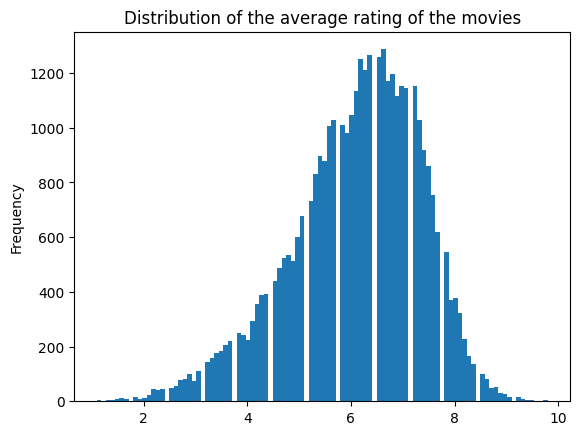

In [30]:
# the distribution of the average rating
df_joined['averageRating'].plot(
    kind='hist', bins=100, title='Distribution of the average rating of the movies')

In [31]:
df_joined['averageRating'].describe()

count    37278.000000
mean         6.103208
std          1.256182
min          1.100000
25%          5.300000
50%          6.300000
75%          7.000000
max          9.800000
Name: averageRating, dtype: float64

<AxesSubplot: title={'center': 'Distribution of the runtime of the movies'}, ylabel='Frequency'>

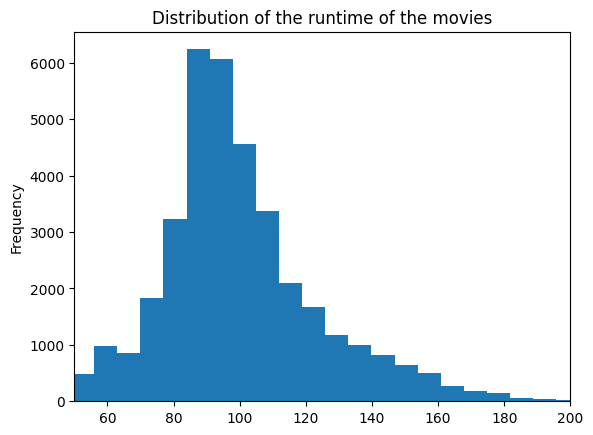

In [32]:
# plot the runtime of the movies
df_joined['runtimeMinutes'] = pd.to_numeric(
    df_joined['runtimeMinutes'], errors='coerce')
df_joined['runtimeMinutes'].plot(kind='hist', bins=100, xlim=(
    50, 200), title='Distribution of the runtime of the movies')

In [33]:
df_joined['runtimeMinutes'].describe()

count    36562.000000
mean       100.181008
std         26.132602
min         21.000000
25%         86.000000
50%         96.000000
75%        110.000000
max        720.000000
Name: runtimeMinutes, dtype: float64

Lets focus on the most popular streaming services in the US,
and check the
number of movies available in each streaming service namely:
(Those streaming services were chosen after reading the following article
[here](https://www.tomsguide.com/us/best-streaming-video-services,review-2625.html))
- Netflix
- Hulu
- Amazon Prime Video
- Disney+
- HBO Max
- Peacock
- Apple TV+

In [34]:
df_joined['on_netflix'] = df_joined['providers'].apply(lambda x: (
    'Netflix' or 'Netflix Kids' or 'Netflix basic with Ads') in x)
df_joined['on_prime'] = df_joined['providers'].apply(
    lambda x: 'Amazon Prime Video' in x)
df_joined['on_apple'] = df_joined['providers'].apply(
    lambda x: 'Apple TV Plus' in x)
df_joined['on_hulu'] = df_joined['providers'].apply(lambda x: 'Hulu' in x)
df_joined['on_disney'] = df_joined['providers'].apply(
    lambda x: 'Disney Plus' in x)
df_joined['on_hbo'] = df_joined['providers'].apply(lambda x: 'HBO Max' in x)
df_joined['on_peacock'] = df_joined['providers'].apply(
    lambda x: ('Peacock' or 'Peacock Premium') in x)

In [35]:
# Count the number of movies per streaming provider
nb_per_streaming_serv = df_joined[[
    'on_netflix', 'on_prime', 'on_apple', 'on_hulu', 'on_disney', 'on_hbo', 'on_peacock']].sum()
print(f'Total number of movies: {nb_per_streaming_serv.sum()}')
nb_per_streaming_serv

Total number of movies: 13390


on_netflix    2915
on_prime      6981
on_apple        42
on_hulu       1058
on_disney      560
on_hbo        1833
on_peacock       1
dtype: int64

<AxesSubplot: title={'center': 'Number of movies per streaming service'}>

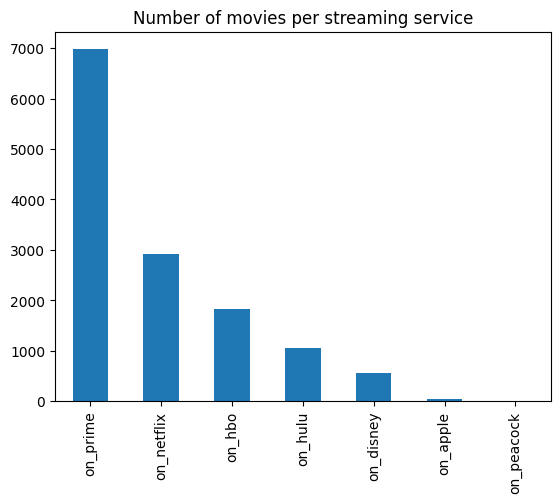

In [36]:
nb_per_streaming_serv.sort_values(ascending=False).plot(
    kind='bar', title='Number of movies per streaming service')

The data is not uniformlly distributed, some streaming services have a
lot of movies and some have very few movies, we will have to find a way
to deal with this problem when performing our analysis.

In [37]:
df_joined['genres'] = df_joined['genres'].apply(lambda x: x.split(','))
genres = set(df_joined['genres'].sum())
genres = list(genres)
# to account for the missing value string '\\N'
print(f'Number of different genres: {len(genres) - 1}')
genres

Number of different genres: 27


['Crime',
 'Sci-Fi',
 'News',
 'Thriller',
 'Sport',
 'Drama',
 'Action',
 'Western',
 'Animation',
 'Mystery',
 'Adult',
 'History',
 'Fantasy',
 'Short',
 'War',
 'Horror',
 'Reality-TV',
 'Biography',
 'Adventure',
 'Talk-Show',
 'Film-Noir',
 '\\N',
 'Musical',
 'Music',
 'Romance',
 'Comedy',
 'Documentary',
 'Family']

<AxesSubplot: title={'center': 'Number of movies per genre in the corrsponding streaming services'}>

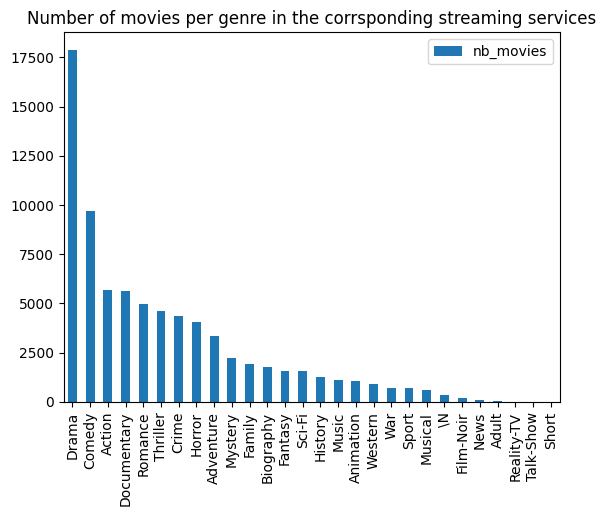

In [38]:
movies_genre = {}
for genre in genres:
    movies_genre[genre] = df_joined['genres'].apply(lambda x: genre in x).sum()
df_movies_genre = pd.DataFrame.from_dict(
    movies_genre, orient='index', columns=['nb_movies'])
# categories of movies on the steaming services defiened above
df_movies_genre.sort_values(by='nb_movies', ascending=False).plot(
    kind='bar', title='Number of movies per genre in the corrsponding streaming services')

Movies can have multiple genres, for example one movie might have the category action and drama which means that
the movie would be counted in both bins.
This concludes our exploration of the dataset, we are now ready to start working on milestone 3.

## NLP exploration
We will now see if we can perform topics extraction over the movie plots.

### Data Loading and basic analysis

In [39]:
df = pd.read_csv('data/moviedb_data.tsv.gz', sep='\t', compression='gzip')
df_plots = df.copy()
# keep only the overview and providers columns as we don't use others for NLP
df_plots = df_plots[['overview', 'providers']]

#### Overview Analysis

In this NLP exploration, we are mostly interested by the overview and providers fields.
Let's see if some movies don't contain overviews.

In [40]:
# print the percentage of movies with no overview
nb_with_no_overview = len(df_plots[df_plots['overview'].isnull()])
print(round(nb_with_no_overview / len(df_plots)
      * 100, 1), '% of movies have a null overview')

# replace the missing values with an empty string
df_plots['overview'] = df_plots['overview'].fillna('')

df_plots.head(8)['overview']

11.7 % of movies have a null overview


0    The adventures of a female reporter in the 1890s.
1    Just as Galeen and Wegener's Der Golem (1915) ...
2    The first feature-length motion picture produc...
3    Australian bushranger movie.  The first filmed...
4    L. Frank Baum would appear in a white suit and...
5                             Know what this is about?
6                                                     
7                             Know what this is about?
Name: overview, dtype: object

Here we see that some movies (5,7) contain a non empty overview, but which indicate that there is no overview for this
movie.
We can replace them by empty overviews. However this replacement may not be exhaustive if some useless plots are not
$\\$ "Know what this is about?" but something else.

In [41]:
n_no_overview_0 = round(
    len(df_plots[df_plots['overview'].str.contains('Know what this is about?')]))
n_no_overview_1 = round(
    len(df_plots[df_plots['overview'].str.contains('No Overview')]))
n_no_overview_2 = round(
    len(df_plots[df_plots['overview'].str.contains('No overview found')]))
total_no_overview = n_no_overview_0 + n_no_overview_1 + \
    n_no_overview_2 + nb_with_no_overview
print(round(total_no_overview / len(df_plots) * 100, 1),
      '% of movies have a no overview')

12.0 % of movies have a no overview


12% of movies without overview are tolerable given that our dataset is large,
but firstly our search is not exhaustive,
and secondly we will $\\$ have to check that most of the movies on the streaming
platforms have an overview to be
able to apply NLP.

In [42]:
# we start by replacing the strings 'No Overview', 'No overview found' and 'Know what this is about?' by an empty string
df_plots['overview'] = df_plots['overview'].apply(lambda x: x.replace(
    'No Overview', '').replace('No overview found', '').replace('Know what this is about?', ''))
# we clean provider data
df_plots['providers'] = df_plots['providers'].fillna('{}')

According to previous analysis, we decided to use providers of Switzerland and US, we will now see if the movies
provided in these $\\$ countries possess enough plots.

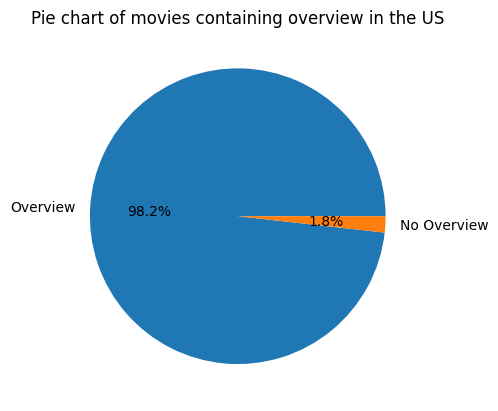

In [43]:
# US provider movies
df_plots_us = df_plots[df_plots['providers'].str.contains('US')]
# keep only movies where plots isn't empty
df_plots_us_overview = df_plots_us[df_plots_us['overview'] != '']

n_plot_us_overview = len(df_plots_us_overview)

plt.title('Pie chart of movies containing overview in the US')
# plot the number of movies with overview in the US
plt.pie([n_plot_us_overview, len(df_plots_us) - n_plot_us_overview], labels=['Overview', 'No Overview'],
        autopct='%1.1f%%')
plt.show()

Thus we can see that we can work on an NLP for topics analysis for the movies provided in US as almost all
movies have plots.

### Plot preparation

Now that we have seen we have enough movies plots in the US region, we can work on our topics analysis. $\\$

We will transform the plots in order to make them intepretable by an LDA model. This includes
- Tokenization
- Lemmatization
- Removing of stopwords

This is usefull as we want to find ressemblance between words, so we should replace words with same meaning by one
common word.
We also want to remove most commun words. This allows to remove low-information words, allowing our
model to focus on important words.

For the below part, we use a smaller dataset for performance reasons as we are trying nlp techniques,
 but in the future we will use $\\$ the full dataset.

#### Tokenization

In [44]:
# take a sample of 10% of the movies
df_plots_us = df_plots_us_overview.sample(frac=0.1, random_state=42)
print(f'Number of movies in the sample: {len(df_plots_us)}')

# Tokenize the plots
df_plots_us['tokenized_plots'] = df_plots_us['overview'].apply(
    lambda movie_plot: word_tokenize(movie_plot))
df_plots_us.head()['tokenized_plots']

Number of movies in the sample: 8031


32771     [Jack, and, Leo, vie, for, the, affections, of...
61864     [Raja, Bhaiya, (, Mithun, Chakraborty, ), and,...
96843     [The, vice, president, is, dead, ,, and, as, t...
211581    [A, monk, must, become, king, ,, and, his, new...
208160    [Growing, up, in, a, small, town, ,, Charlie, ...
Name: tokenized_plots, dtype: object

#### Lemmatization
we start by assocating a POS tag to each word (i.e if a word is a Noun, Verb, Adjective, etc.)

In [45]:
df_plots_us['plots_with_POS_tag'] = df_plots_us['tokenized_plots'].apply(
    lambda tokenized_plot: pos_tag(tokenized_plot))
df_plots_us['plots_with_POS_tag'].head()

32771     [(Jack, NNP), (and, CC), (Leo, NNP), (vie, NN)...
61864     [(Raja, NNP), (Bhaiya, NNP), ((, (), (Mithun, ...
96843     [(The, DT), (vice, NN), (president, NN), (is, ...
211581    [(A, DT), (monk, NN), (must, MD), (become, VB)...
208160    [(Growing, VBG), (up, RP), (in, IN), (a, DT), ...
Name: plots_with_POS_tag, dtype: object

If a word has no tag we don't change it. However if there is a tag, we lemmatize the word according to its tag.

In [46]:
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()
# Lemmatize each word given its POS tag
df_plots_us['lemmatized_plots'] = df_plots_us['plots_with_POS_tag'].apply(
    lambda tokenized_plot: [word[0] if nlp_helper.get_wordnet_pos(word[1]) == ''
                            else lemmatizer.lemmatize(word[0], nlp_helper.get_wordnet_pos(word[1]))
                            for word in tokenized_plot])
df_plots_us['lemmatized_plots'].head()

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/douglasbouchet/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


32771     [Jack, and, Leo, vie, for, the, affection, of,...
61864     [Raja, Bhaiya, (, Mithun, Chakraborty, ), and,...
96843     [The, vice, president, be, dead, ,, and, as, t...
211581    [A, monk, must, become, king, ,, and, his, new...
208160    [Growing, up, in, a, small, town, ,, Charlie, ...
Name: lemmatized_plots, dtype: object

#### Stop words removal

In [47]:
# list of stop words could be improved
stop_words = ['\'s']
all_stopwords = stopwords.words(
    'English') + list(string.punctuation) + stop_words

In [48]:

# remove the white space inside each words
df_plots_us['plots_without_stopwords'] = df_plots_us['lemmatized_plots'].apply(
    lambda tokenized_plot: [word.strip() for word in tokenized_plot])
# lowercase all words in each plot
df_plots_us['plots_without_stopwords'] = df_plots_us['plots_without_stopwords'].apply(
    lambda plot: [word.lower() for word in plot])
# remove stopwords from the plots
df_plots_us['plots_without_stopwords'] = df_plots_us['plots_without_stopwords'].apply(
    lambda plot: [word for word in plot if word not in all_stopwords])
# remove word if contains other letter than a-z or is a single character
df_plots_us['plots_without_stopwords'] = df_plots_us['plots_without_stopwords'].apply(
    lambda plot: [word for word in plot if word.isalpha() and len(word) > 1])
df_plots_us['plots_without_stopwords'].head()[0:2]

/var/folders/2v/f5sm00lj343gkrnlrbwvbls00000gn/T/ipykernel_83464/3559798038.py:13: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df_plots_us['plots_without_stopwords'].head()[0:2]


32771    [jack, leo, vie, affection, appear, little, di...
61864    [raja, bhaiya, mithun, chakraborty, friend, ch...
Name: plots_without_stopwords, dtype: object

In [49]:
before_stop_words_total_number_of_words =\
    len([word for sentence in df_plots_us['lemmatized_plots']
        for word in sentence])
after_stop_words_total_number_of_words =\
    len([word for sentence in df_plots_us['plots_without_stopwords']
        for word in sentence])
print('We kept {}% of the words in the corpus'.format(
    round(after_stop_words_total_number_of_words/before_stop_words_total_number_of_words, 2) * 100))

We kept 49.0% of the words in the corpus


### Latent Direchlet Allocation
We need to create a list of tokens, i.e words that will be used inside our dictionary (depending on their frequency).
$\\$
We can start by creating bi-gram for some words (represent to one words by one unique composed word)
It can be also interesting to see $\\$ if creating tri-gram allows to extract more information from plots.

In [50]:
tokens = df_plots_us['plots_without_stopwords'].tolist()
bigram_model = Phrases(tokens)
tokens = list(bigram_model[tokens])
print(tokens[0:2])

[['jack', 'leo', 'vie', 'affection', 'appear', 'little', 'differently', 'course', 'series', 'energetic', 'sketch', 'flashback', 'homage'], ['raja', 'bhaiya', 'mithun', 'chakraborty', 'friend', 'charan', 'satish', 'kaushik', 'come', 'city', 'make_living', 'failed', 'attempt', 'find', 'job', 'one_day', 'tease', 'rag', 'kallu', 'dada', 'ranjeet', 'quarrel', 'get', 'physical', 'raja', 'win', 'raja', 'thus', 'become', 'local', 'underworld', 'start', 'collect', 'protection', 'money', 'shopkeeper', 'become', 'addict', 'alcohol', 'raja', 'life', 'take', 'twist_turn', 'mohan', 'rao', 'nilu', 'phule', 'pass_away']]


#### Hyperparameters

In [51]:
no_below = 60  # minimum number of documents a word must be present in to be kept
no_above = 0.5  # maximum proportion of documents a word can be present in to be kept
n_topics = 10  # number of topics
n_passes = 10  # number of passes through the corpus during training

### Dictionnary & Corpus
The dictionnary will be the list of unique words, and the corpus a list of movie plots bag of words.

In [52]:
# we create a dictionary that maps each word to a unique integer
# we also create a corpus. Each movie plot is encoded as a bag of words in the corpus.
# A bag of word means that we count the number of times each word appears in the mvoie plot
dictionary, corpus = nlp_helper.build_dictionnary_and_corpus(
    tokens, no_below=no_below, no_above=no_above)
print('Dictionary size: {}'.format(len(dictionary)))
print('Dictionary first 10 elements: {}'.format(
    list(dictionary.items())[0:10]))
print('Corpus size: {}'.format(len(corpus)))
print('Corpus first 2 elements: {}'.format(corpus[0:2]))

Dictionary size: 564
Dictionary first 10 elements: [(0, 'appear'), (1, 'course'), (2, 'jack'), (3, 'little'), (4, 'series'), (5, 'attempt'), (6, 'become'), (7, 'city'), (8, 'come'), (9, 'find')]
Corpus size: 8031
Corpus first 2 elements: [[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)], [(5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1)]]


#### LDA Model

In [53]:
np.random.seed(9999)
lda_model = nlp_helper.create_lda_model(
    corpus, dictionary, num_topics=n_topics, passes=n_passes)

In [54]:
# get the topics
topics = nlp_helper.get_topics(lda_model, num_topics=n_topics, num_words=10)
# print topics with new line
for i, topic in enumerate(topics):
    print('Topic {}: {}'.format(i, topic))

Topic 0: man father woman go must son team kill want daughter
Topic 1: two take world young work time try home live people
Topic 2: face dream plan human new_york race could adventure state earth
Topic 3: get mother force wife run child return house back move
Topic 4: end war send still different young_man modern next filmmaker drama
Topic 5: documentary together include long create problem seek director kid everyone
Topic 6: girl past night three last power give four many hide
Topic 7: life find one story film love friend new become make
Topic 8: family boy change save gang whose village killer party question
Topic 9: help fight head happen land marry stay indian drug believe


From these topics, we could interpret the 0th as more drama movies, whereas the 2th could be more adventurous movies.
However some others topics aren't really good, we cannot find a true ressemblance between the words inside.
We will work in the future of this project on how to improve our model to have miningfull topics.

In [55]:
# for each movie plot, get its topic distribution (i.e the probability of each topic) in descending order
topic_distributions = nlp_helper.get_topic_distribution(lda_model, corpus)
print('Movie plot: {}'.format(df_plots['overview'].iloc[0]))
print('Topic distribution for the first movie plot: {}'.format(
    topic_distributions[0]))

Movie plot: The adventures of a female reporter in the 1890s.
Topic distribution for the first movie plot: [(7, 0.25232968), (1, 0.19633093), (0, 0.1665312), (3, 0.09325878), (8, 0.06910921), (9, 0.057907745), (6, 0.052835457), (2, 0.047593594), (5, 0.03533027), (4, 0.028773118)]


Here we see that the movie plot is mainly disrtributed on topics 7,1,0 which are related to love, traveling,
and drama.
This could actually make sens given the movie plot.